# Constant-Gain Linear Controller vs Optimal $w^*$

This notebook simulates a linear feedback controller $u_t = K \cdot b_t$ for the storage model, collects the resulting trajectories $(b_t, u_t, c_t)$, and compares its performance with the offline optimal controller $w^*$.


**Workflow**
1. Configure the horizon and choose arrival/cost models from the project registries.
2. Solve the offline convex program to obtain $w^*$.
3. Simulate the constant-gain policy $u_t = K b_t$ and compute per-step costs.
4. Visualize trajectories and compare aggregate costs across several $K$ values.


In [152]:

from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.arrivals import ARRIVAL_FUNCTIONS
from src.costs import COST_FUNCTIONS
from src.offline_opt import solve_optimal_w
from src.utils import simulate_storage_dynamics, compare_controllers


In [153]:
# --- Simulation parameters ---
T = 200            # horizon length
H = 20             # feature dimension for w*
kappa = 0.1        # decay parameter for feature construction
K = 0.56               # constant feedback gain (0 <= K <= 1)
a_mode = 'random'   # arrivals key from ARRIVAL_FUNCTIONS
cost_key = 'adversarial_time_variant'  # cost key from COST_FUNCTIONS
#cost_key = 'burst_randomized'
#cost_key = 'linear_-b'
amplitude = 1
a_kwargs = {}
cost_kwargs = {}
b0 = 0.0
K_grid = np.linspace(kappa, 1.0, 100)  # optional sweep for multiple gains


In [154]:
def simulate_constant_gain(K, arrivals, cost_fn, *, cost_kwargs=None, b0=0.0):
    """Simulate u_t = K * b_t with backlog recursion b_{t+1} = b_t - u_t + a_t."""
    if cost_kwargs is None:
        cost_kwargs = {}
    K_clipped = float(np.clip(K, 0.0, 1.0))
    T = len(arrivals)
    b_levels = np.empty(T)
    u_actions = np.empty(T)
    costs = np.empty(T)
    b_t = float(b0)
    for t in range(T):
        b_levels[t] = b_t
        u_t = K_clipped * b_t
        u_actions[t] = u_t
        costs[t] = cost_fn(b_t, u_t, t + 1, **cost_kwargs)
        b_t = b_t - u_t + arrivals[t]
    return {'b': b_levels, 'u': u_actions, 'c': costs}


In [155]:
# Solve the offline problem to obtain w* for the configured instance
opt_result = solve_optimal_w(
    a_mode=a_mode,
    cost_key=cost_key,
    T=T,
    H=H,
    kappa=kappa,
    amplitude=amplitude,
    cost_kwargs=cost_kwargs,
    a_kwargs=a_kwargs,
    verbose=False
)

a = opt_result['a']
cost_fn = opt_result['cost_fn']
Phi = opt_result['Phi']
Psi = opt_result['Psi']
w_star = opt_result['w_star']
sim_optimal = simulate_storage_dynamics(Phi, Psi, a, w_star, cost_fn, cost_kwargs=cost_kwargs)
total_cost_opt = float(np.sum(sim_optimal['c']))
print(f'Total cost for w*: {total_cost_opt:.4f}')



──────────────────────────────
Optimal weight vector found for 'random' | cost='adversarial_time_variant'
Objective value: 24.9063
w* (rounded): [0.2626 0.     0.2096 0.     0.2224 0.     0.1799 0.     0.1254 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
Sum(w*): 1.0000
──────────────────────────────
Total cost for w*: 24.9063


In [156]:
# Simulate the constant-gain controller
sim_constant = simulate_constant_gain(K, a, cost_fn, cost_kwargs=cost_kwargs, b0=b0)
total_cost_constant = float(np.sum(sim_constant['c']))
print(f'Total cost for K={K:.2f}: {total_cost_constant:.4f}')


Total cost for K=0.56: 26.2290


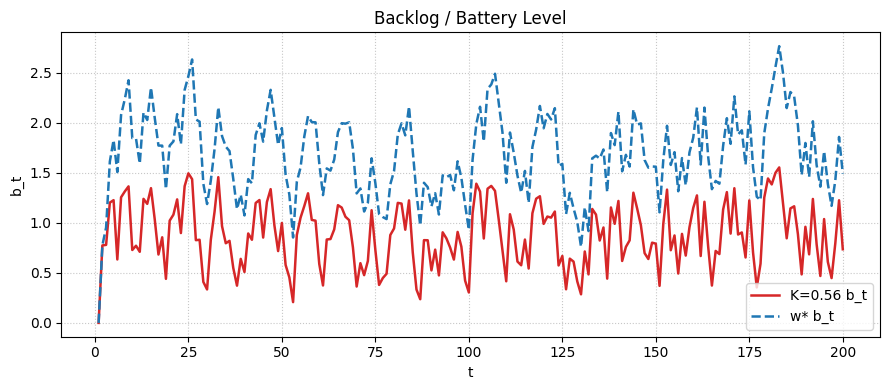

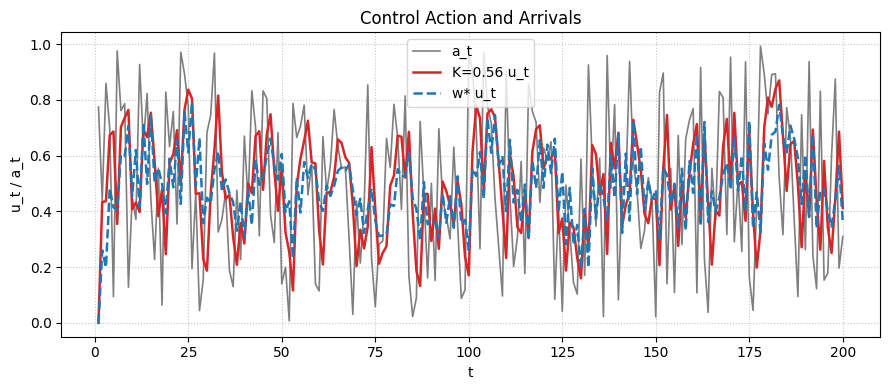

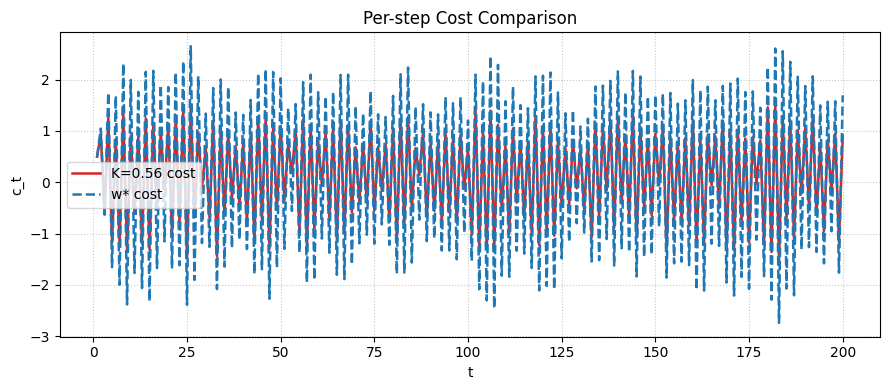


──────────────────────────────
K=0.56          Total cost: 26.2290
w*              Total cost: 24.9063
──────────────────────────────


{'total_cost_1': np.float64(26.22903454995063),
 'total_cost_2': np.float64(24.90634633414725),
 'b_diff': np.float64(0.8052951872227263),
 'u_diff': np.float64(0.08566428620447653),
 'cost_diff': np.float64(0.8095865773684455)}

In [157]:
# Visual comparison of trajectories and per-step costs
comparison_metrics = compare_controllers(
    sim_constant, f'K={K:.2f}',
    sim_optimal, 'w*',
    a=a,
    plot_len=min(200, T)
)
comparison_metrics


Best K on grid: 0.34 with total cost 25.6788
w* total cost : 24.9063


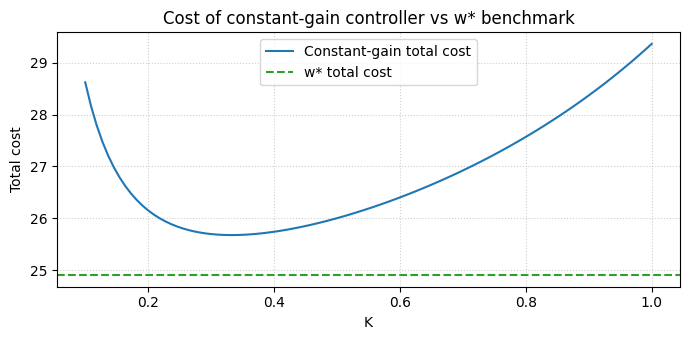

In [158]:
# Sweep over multiple K values to see how the aggregate cost changes
grid_costs = []
for candidate in K_grid:
    sim = simulate_constant_gain(candidate, a, cost_fn, cost_kwargs=cost_kwargs, b0=b0)
    grid_costs.append(np.sum(sim['c']))
grid_costs = np.array(grid_costs)
best_idx = int(np.argmin(grid_costs))
best_K = float(K_grid[best_idx])
print(f'Best K on grid: {best_K:.2f} with total cost {grid_costs[best_idx]:.4f}')
print(f'w* total cost : {total_cost_opt:.4f}')

plt.figure(figsize=(7, 3.5))
plt.plot(K_grid, grid_costs, label='Constant-gain total cost')
plt.axhline(total_cost_opt, color='tab:green', linestyle='--', label='w* total cost')
plt.xlabel('K')
plt.ylabel('Total cost')
plt.title('Cost of constant-gain controller vs w* benchmark')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
